In [39]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho các biểu đồ
sns.set_style("whitegrid")  # Using direct seaborn styling instead of plt.style.use
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

file_path = '../dataset/train_segmented.csv'
df = pd.read_csv(file_path)

# Create a copy of the original dataframe for later reference
df_original = df.copy()

In [40]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Xác định các loại cột
numerical_cols = ['case_thickness', 'case_diameter', 'water_resistance']
onehot_cols = ['gender', 'movement', 'watch_style']
categorical_cols = ['case_material', 'band_material', 'case_back', 'bezel_material', 
                    'brand', 'crystal', 'hands', 'dial_markers']

all_categorical_cols = onehot_cols + categorical_cols
high_card_cols = [col for col in all_categorical_cols if df[col].nunique() > 10]
low_card_cols = [col for col in all_categorical_cols if col not in high_card_cols]

# Category pooling (gộp nhóm các giá trị hiếm) - quan trọng cho Agglomerative Clustering
def pool_categories(series, threshold=0.01):
    value_counts = series.value_counts(normalize=True)
    rare = value_counts[value_counts < threshold].index
    return series.apply(lambda x: 'Other' if x in rare else x)

# Gộp giá trị hiếm cho các cột có nhiều category
df_processed = df.copy()
for col in high_card_cols:
    df_processed[col] = pool_categories(df_processed[col])

# Frequency Encoding cho các cột có nhiều category sau khi đã gộp
for col in high_card_cols:
    freq_map = df_processed[col].value_counts(normalize=True).to_dict()
    df_processed[col] = df_processed[col].map(freq_map)

# One-hot Encoding cho các cột có ít category
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
if low_card_cols:
    onehot_encoded = pd.DataFrame(
        onehot_encoder.fit_transform(df_processed[low_card_cols]),
        columns=onehot_encoder.get_feature_names_out(low_card_cols)
    )
    
    # Chuẩn hóa dữ liệu số - cần thiết cho Agglomerative Clustering
    scaler = StandardScaler()
    scaled_numerical = pd.DataFrame(
        scaler.fit_transform(df_processed[numerical_cols]),
        columns=numerical_cols
    )
    
    # Kết hợp dữ liệu đã xử lý
    df_gmm = pd.concat([
        scaled_numerical,
        onehot_encoded,
        df_processed[high_card_cols]
    ], axis=1)
else:
    # Chuẩn hóa dữ liệu số
    scaler = StandardScaler()
    scaled_numerical = pd.DataFrame(
        scaler.fit_transform(df_processed[numerical_cols]),
        columns=numerical_cols
    )
    
    # Kết hợp dữ liệu đã xử lý
    df_gmm = pd.concat([
        scaled_numerical,
        df_processed[high_card_cols]
    ], axis=1)

print("\n=== KIỂM TRA DỮ LIỆU SAU KHI TIỀN XỬ LÝ CHO AGGLOMERATIVE CLUSTERING ===")
print("\nDữ liệu đã được chuẩn hóa và mã hóa:")
print(df_gmm.head())
print(f"\nKích thước dữ liệu: {df_gmm.shape}")

# Lưu dữ liệu đã xử lý
df_gmm.to_csv('../dataset/train_agglomerative_processed.csv', index=False)

df_agg = df_gmm.copy()


=== KIỂM TRA DỮ LIỆU SAU KHI TIỀN XỬ LÝ CHO AGGLOMERATIVE CLUSTERING ===

Dữ liệu đã được chuẩn hóa và mã hóa:
   case_thickness  case_diameter  water_resistance  gender_UNISEX  \
0       -0.962829      -0.767582         -0.281839            0.0   
1       -0.687852      -0.097288         -0.281839            0.0   
2        0.215643       1.075727          0.006708            0.0   
3       -1.316370      -1.437877         -0.397257            0.0   
4       -0.021551       0.237859         -0.281839            0.0   

   gender_WOMENS  movement_Eco-Drive  movement_Hand Wind  movement_Quartz  \
0            1.0                 0.0                 0.0              0.0   
1            0.0                 0.0                 0.0              1.0   
2            0.0                 0.0                 0.0              1.0   
3            1.0                 0.0                 0.0              1.0   
4            0.0                 0.0                 0.0              1.0   

   watch_s

Applying PCA for dimensionality reduction...
Original dimensions: 24
Reduced dimensions with PCA: 12
Explained variance ratio: [0.40216939 0.19892263 0.12517972 0.08898296 0.03644619 0.02388397
 0.02045894 0.01742123 0.01480097 0.01018985 0.00950056 0.00856678]
Total explained variance: 0.9565


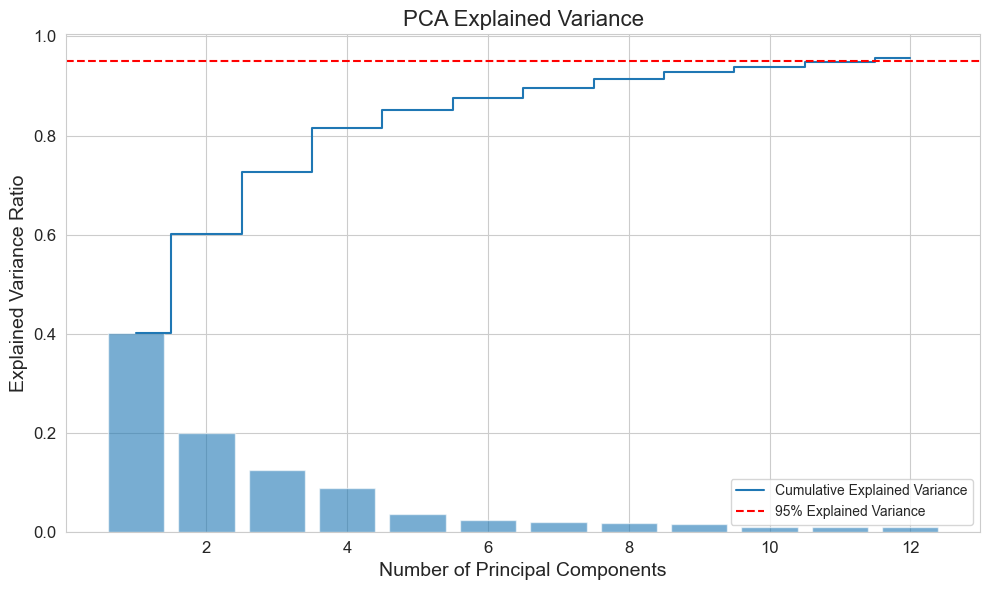

In [41]:
# Apply PCA for dimensionality reduction
# This will help with visualization and improve performance of clustering algorithms
from sklearn.decomposition import PCA

print("Applying PCA for dimensionality reduction...")
pca = PCA(n_components=0.95)  # Keep 95% of variance
df_pca = pd.DataFrame(pca.fit_transform(df_gmm))

print(f"Original dimensions: {df_gmm.shape[1]}")
print(f"Reduced dimensions with PCA: {df_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Visualize the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.6)
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
#
# # Nếu bạn có `df_pca` và `kproto_clusters`
# plt.figure(figsize=(10, 6))
# plt.scatter(df_pca[0], df_pca[1], c=kproto_clusters, cmap='tab10', alpha=0.7)
# plt.title('PCA Visualization of Clusters (K-Prototypes)')
# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')
# plt.colorbar(label='Cluster')
# plt.show()


Đang xác định số cụm và kiểu covariance tối ưu cho GMM...

Đang kiểm tra covariance_type = 'full'
n_components = 2, BIC = 26486.71, AIC = 25284.50
n_components = 3, BIC = -10544.90, AIC = -12351.54
n_components = 4, BIC = -64467.81, AIC = -66878.88
n_components = 5, BIC = -81516.92, AIC = -84532.42
n_components = 6, BIC = -97504.46, AIC = -101124.38
n_components = 7, BIC = -92679.48, AIC = -96903.83


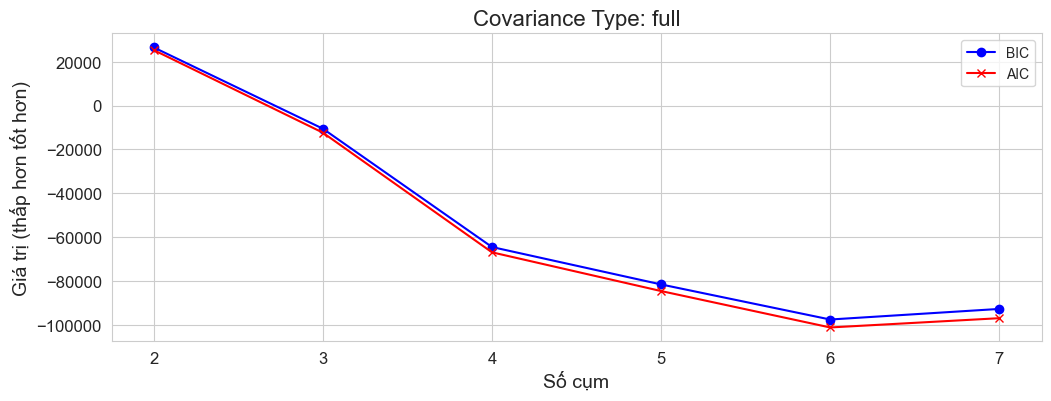

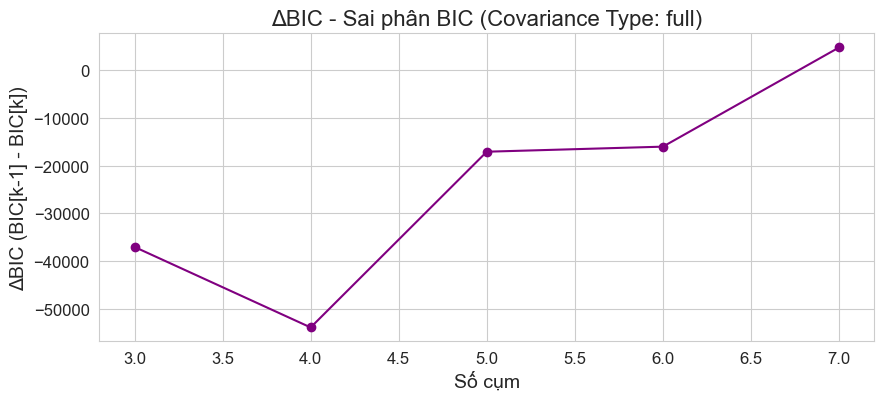


Đang kiểm tra covariance_type = 'tied'
n_components = 2, BIC = 49920.30, AIC = 49236.16
n_components = 3, BIC = 40043.51, AIC = 39273.04
n_components = 4, BIC = 36720.18, AIC = 35863.35
n_components = 5, BIC = 31924.28, AIC = 30981.11
n_components = 6, BIC = 15325.17, AIC = 14295.65
n_components = 7, BIC = 14203.55, AIC = 13087.68


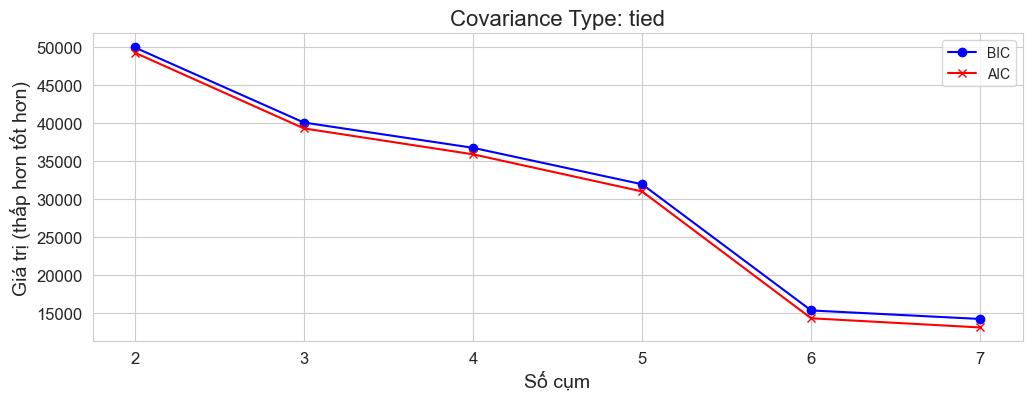

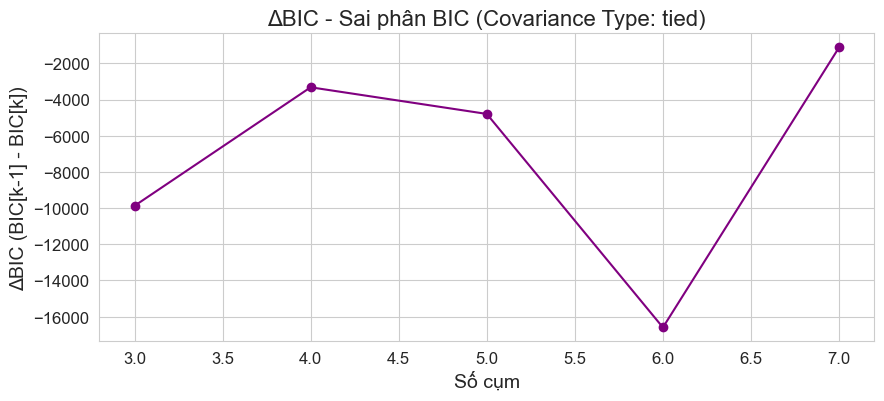


Đang kiểm tra covariance_type = 'diag'
n_components = 2, BIC = 62251.24, AIC = 61925.78
n_components = 3, BIC = 50714.22, AIC = 50222.70
n_components = 4, BIC = 38635.55, AIC = 37977.98
n_components = 5, BIC = 33154.60, AIC = 32330.98
n_components = 6, BIC = 31355.71, AIC = 30366.05
n_components = 7, BIC = 28971.83, AIC = 27816.11


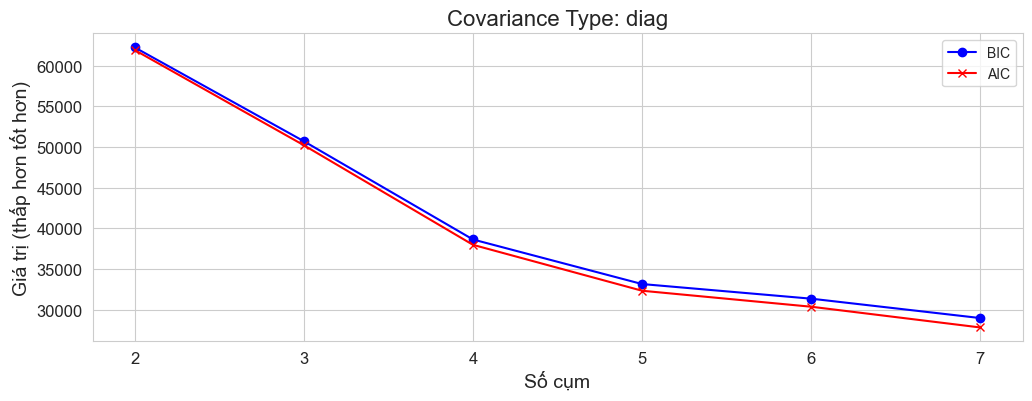

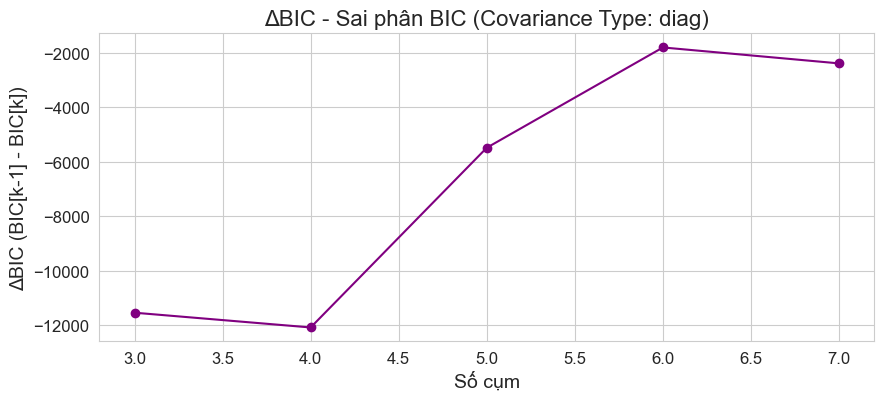


Đang kiểm tra covariance_type = 'spherical'
n_components = 2, BIC = 106662.13, AIC = 106482.80
n_components = 3, BIC = 84351.01, AIC = 84078.68
n_components = 4, BIC = 77841.29, AIC = 77475.98
n_components = 5, BIC = 69801.85, AIC = 69343.55
n_components = 6, BIC = 65224.10, AIC = 64672.81
n_components = 7, BIC = 63095.58, AIC = 62451.30


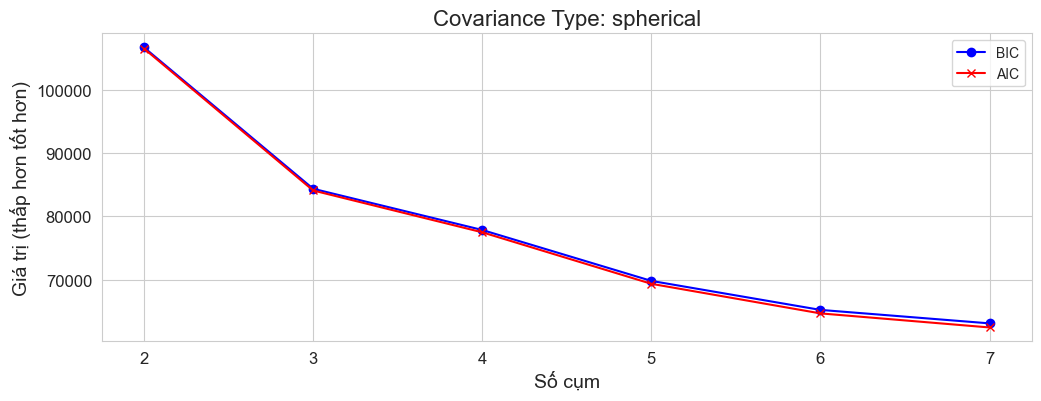

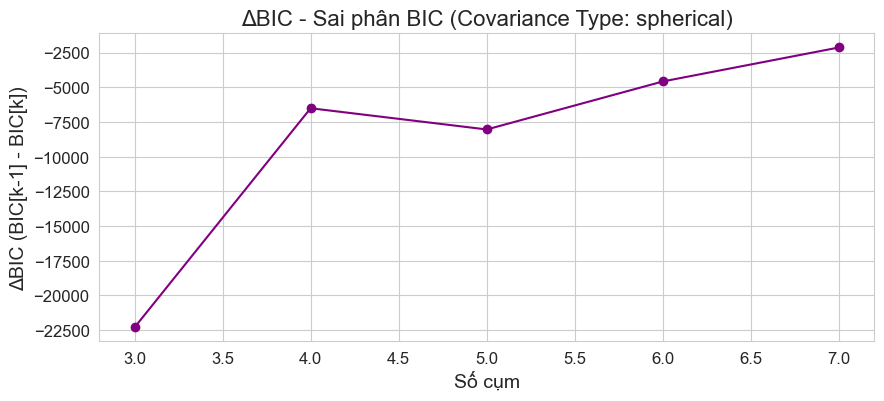


✅ Kết quả tốt nhất theo BIC:
Số cụm tối ưu: 6
Covariance type tối ưu: full
Giá trị BIC: -97504.46
Giá trị AIC: -101124.38

🔍 Tính Silhouette Score với covariance_type = full
n_components = 2, Silhouette Score = 0.1566
n_components = 3, Silhouette Score = 0.1239
n_components = 4, Silhouette Score = 0.0964
n_components = 5, Silhouette Score = 0.1069
n_components = 6, Silhouette Score = 0.0696
n_components = 7, Silhouette Score = 0.0611


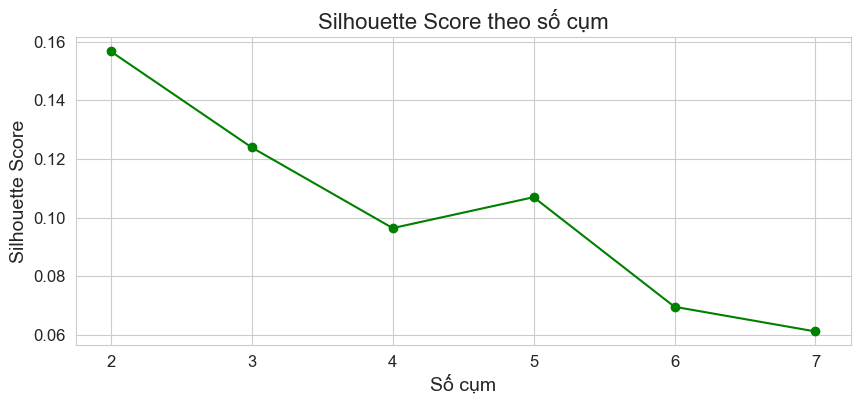


📉 Tính Davies-Bouldin Index với covariance_type = full
n_components = 2, DB Index = 2.3458
n_components = 3, DB Index = 3.0489
n_components = 4, DB Index = 2.9287
n_components = 5, DB Index = 2.5295
n_components = 6, DB Index = 2.5641
n_components = 7, DB Index = 2.9036


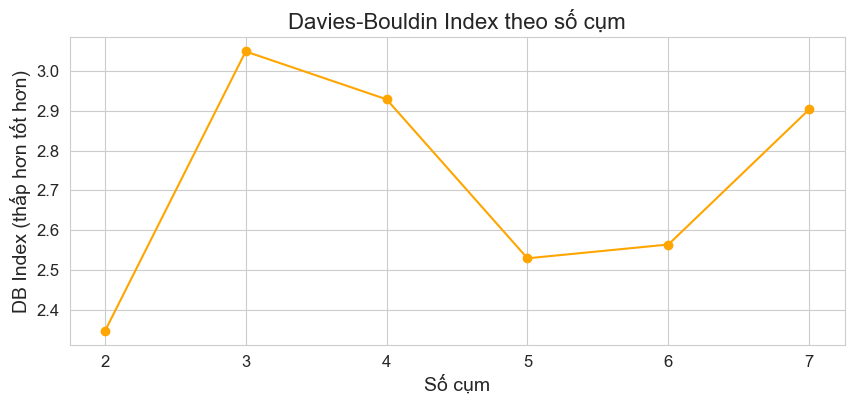

In [42]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt

print("Đang xác định số cụm và kiểu covariance tối ưu cho GMM...")

n_components_range = range(2, 8)
covariance_types = ['full', 'tied', 'diag', 'spherical']

results = []

for cov_type in covariance_types:
    bic_scores = []
    aic_scores = []

    print(f"\nĐang kiểm tra covariance_type = '{cov_type}'")

    for n_components in n_components_range:
        try:
            gmm = GaussianMixture(
                n_components=n_components,
                covariance_type=cov_type,
                random_state=42,
                max_iter=100,
                n_init=3
            )
            gmm.fit(df_pca)

            bic = gmm.bic(df_pca)
            aic = gmm.aic(df_pca)

            bic_scores.append(bic)
            aic_scores.append(aic)

            print(f"n_components = {n_components}, BIC = {bic:.2f}, AIC = {aic:.2f}")

            results.append({
                'n_components': n_components,
                'covariance_type': cov_type,
                'bic': bic,
                'aic': aic,
                'model': gmm
            })

        except Exception as e:
            print(f"Lỗi với n_components = {n_components}, covariance_type = {cov_type}: {e}")
            bic_scores.append(np.nan)
            aic_scores.append(np.nan)

    # Vẽ biểu đồ BIC/AIC
    plt.figure(figsize=(12, 4))
    plt.plot(n_components_range, bic_scores, label='BIC', marker='o', color='blue')
    plt.plot(n_components_range, aic_scores, label='AIC', marker='x', color='red')
    plt.title(f"Covariance Type: {cov_type}")
    plt.xlabel("Số cụm")
    plt.ylabel("Giá trị (thấp hơn tốt hơn)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Vẽ sai phân BIC (ΔBIC)
    delta_bic = np.diff(bic_scores)
    plt.figure(figsize=(10, 4))
    plt.plot(n_components_range[1:], delta_bic, marker='o', linestyle='-', color='purple')
    plt.title(f"ΔBIC - Sai phân BIC (Covariance Type: {cov_type})")
    plt.xlabel("Số cụm")
    plt.ylabel("ΔBIC (BIC[k-1] - BIC[k])")
    plt.grid(True)
    plt.show()

# Chọn mô hình có BIC tốt nhất
best_result = min(results, key=lambda x: x['bic'])

print("\n✅ Kết quả tốt nhất theo BIC:")
print(f"Số cụm tối ưu: {best_result['n_components']}")
print(f"Covariance type tối ưu: {best_result['covariance_type']}")
print(f"Giá trị BIC: {best_result['bic']:.2f}")
print(f"Giá trị AIC: {best_result['aic']:.2f}")

# GMM tốt nhất
best_cov_type = best_result['covariance_type']
best_gmm = best_result['model']

# --- Silhouette Score ---
print("\n🔍 Tính Silhouette Score với covariance_type =", best_cov_type)
sil_scores = []

for n_components in n_components_range:
    try:
        gmm = GaussianMixture(n_components=n_components, covariance_type=best_cov_type, random_state=42)
        gmm.fit(df_pca)
        labels = gmm.predict(df_pca)
        sil = silhouette_score(df_pca, labels)
        sil_scores.append(sil)
        print(f"n_components = {n_components}, Silhouette Score = {sil:.4f}")
    except:
        sil_scores.append(np.nan)

plt.figure(figsize=(10, 4))
plt.plot(n_components_range, sil_scores, marker='o', color='green')
plt.title("Silhouette Score theo số cụm")
plt.xlabel("Số cụm")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# --- Davies-Bouldin Index ---
print("\n📉 Tính Davies-Bouldin Index với covariance_type =", best_cov_type)
db_scores = []

for n_components in n_components_range:
    try:
        gmm = GaussianMixture(n_components=n_components, covariance_type=best_cov_type, random_state=42)
        gmm.fit(df_pca)
        labels = gmm.predict(df_pca)
        db = davies_bouldin_score(df_pca, labels)
        db_scores.append(db)
        print(f"n_components = {n_components}, DB Index = {db:.4f}")
    except:
        db_scores.append(np.nan)

plt.figure(figsize=(10, 4))
plt.plot(n_components_range, db_scores, marker='o', color='orange')
plt.title("Davies-Bouldin Index theo số cụm")
plt.xlabel("Số cụm")
plt.ylabel("DB Index (thấp hơn tốt hơn)")
plt.grid(True)
plt.show()

# Gán nhãn cụm vào df_original để phục vụ trực quan hóa phía sau
df_original['gmm_cluster'] = best_gmm.predict(df_pca)

# 5. Trực quan hóa kết quả phân cụm GMM

Chúng ta sẽ giảm chiều dữ liệu xuống 2 thành phần chính bằng PCA và trực quan hóa các cụm GMM trên không gian này để so sánh với Agglomerative Clustering.

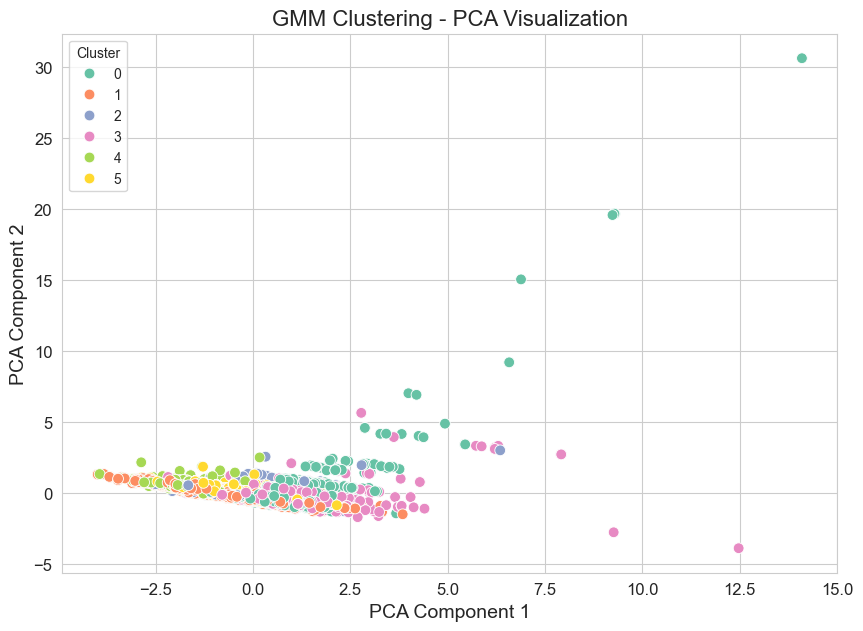

Phương sai giải thích bởi 2 thành phần chính: 60.11%
PCA1: 40.22%, PCA2: 19.89%


In [43]:
# Giảm chiều dữ liệu xuống 2 thành phần chính để trực quan hóa
from sklearn.decomposition import PCA

pca_vis = PCA(n_components=2)
pca_2d = pca_vis.fit_transform(df_gmm)
df_original['pca_1'] = pca_2d[:, 0]
df_original['pca_2'] = pca_2d[:, 1]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_original, x='pca_1', y='pca_2', hue='gmm_cluster', palette='Set2', s=60)
plt.title('GMM Clustering - PCA Visualization', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

explained_var = pca_vis.explained_variance_ratio_
print(f"Phương sai giải thích bởi 2 thành phần chính: {sum(explained_var)*100:.2f}%")
print(f"PCA1: {explained_var[0]*100:.2f}%, PCA2: {explained_var[1]*100:.2f}%")

## 6. Phân tích đặc điểm của các cụm GMM

### 6.1. Phân tích đặc trưng số

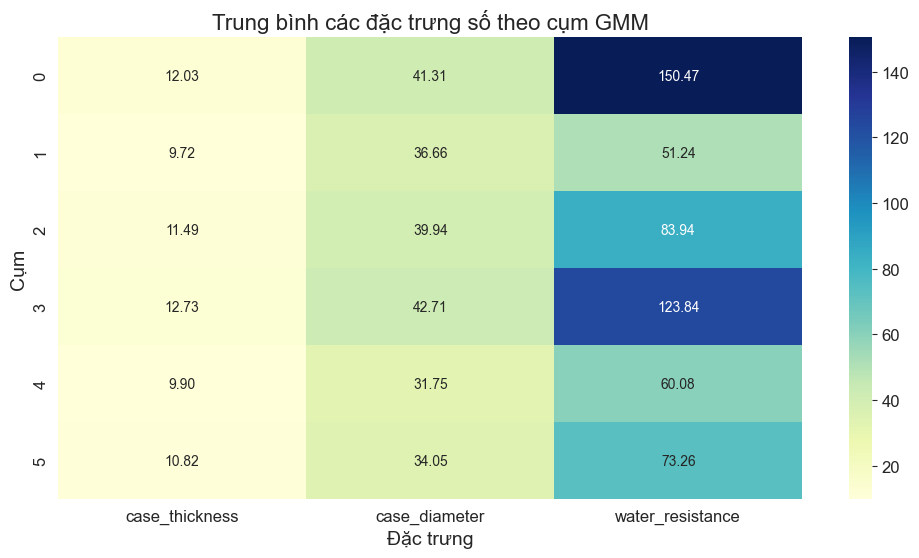

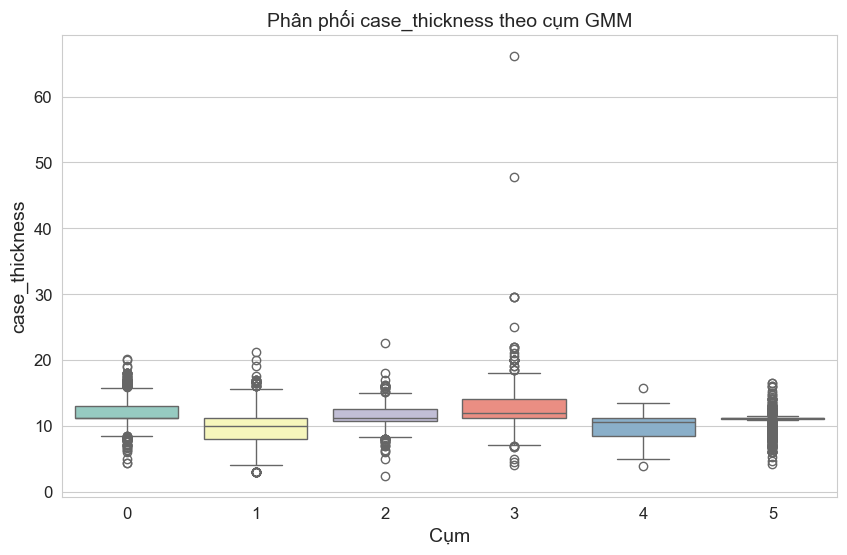

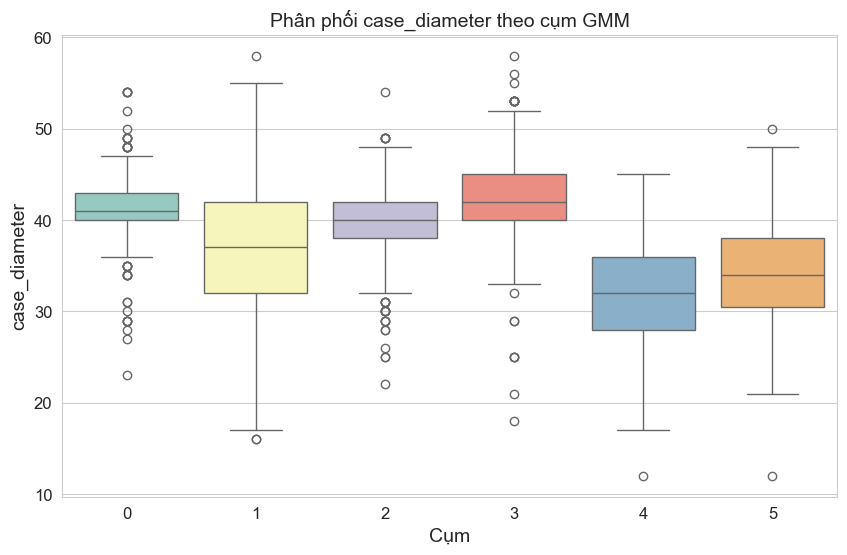

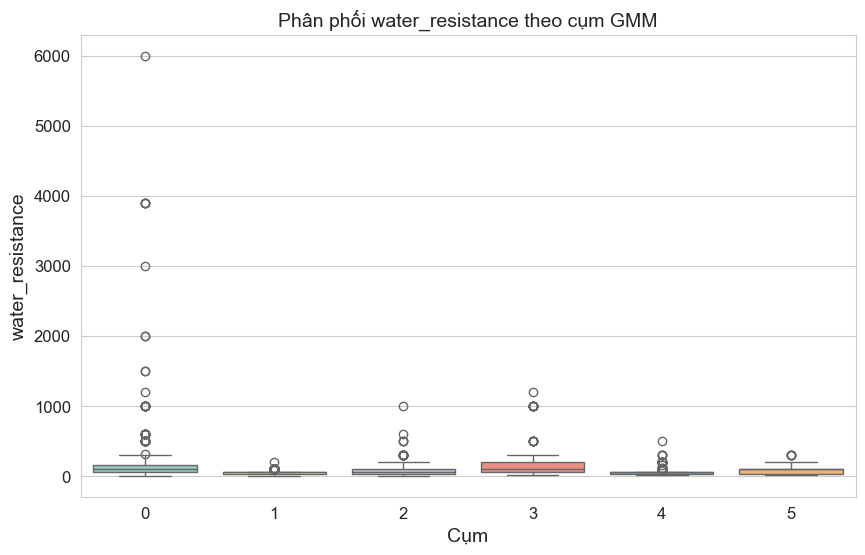

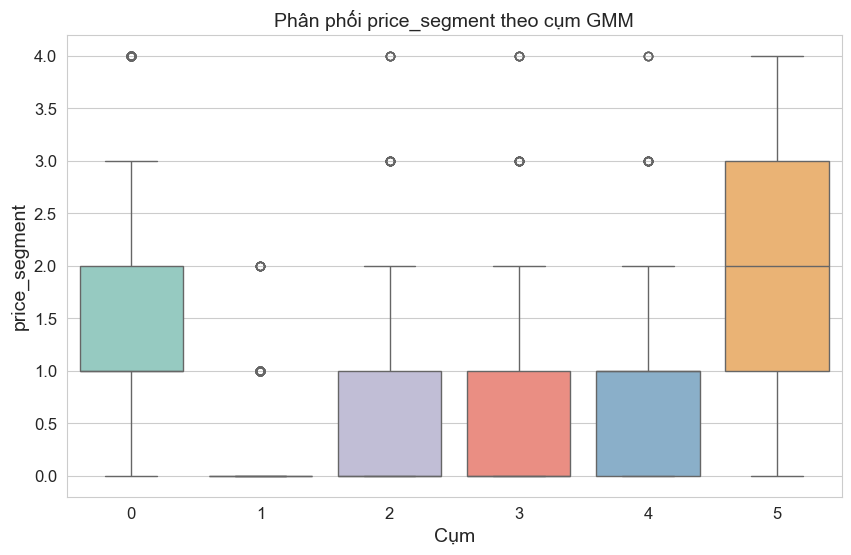

In [44]:
# Trung bình các đặc trưng số theo cụm GMM
num_cols = ['case_thickness', 'case_diameter', 'water_resistance']
cluster_means = df_original.groupby('gmm_cluster')[num_cols].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Trung bình các đặc trưng số theo cụm GMM', fontsize=16)
plt.ylabel('Cụm')
plt.xlabel('Đặc trưng')
plt.show()

# Boxplot cho từng đặc trưng số và price_segment theo cụm
for col in num_cols + ['price_segment']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_original, x='gmm_cluster', y=col, palette='Set3')
    plt.title(f'Phân phối {col} theo cụm GMM', fontsize=14)
    plt.xlabel('Cụm')
    plt.ylabel(col)
    plt.show()

### 6.2. Phân tích đặc trưng phân loại theo cụm GMM

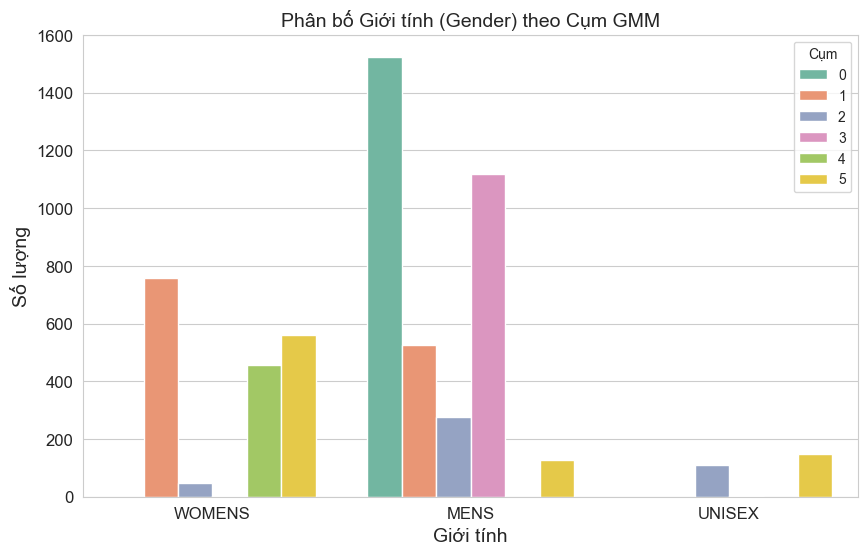

<Figure size 1000x600 with 0 Axes>

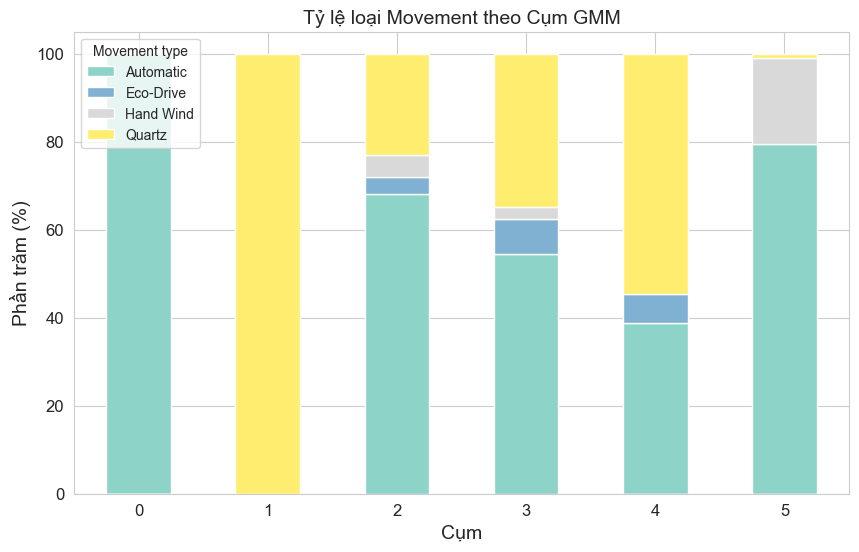

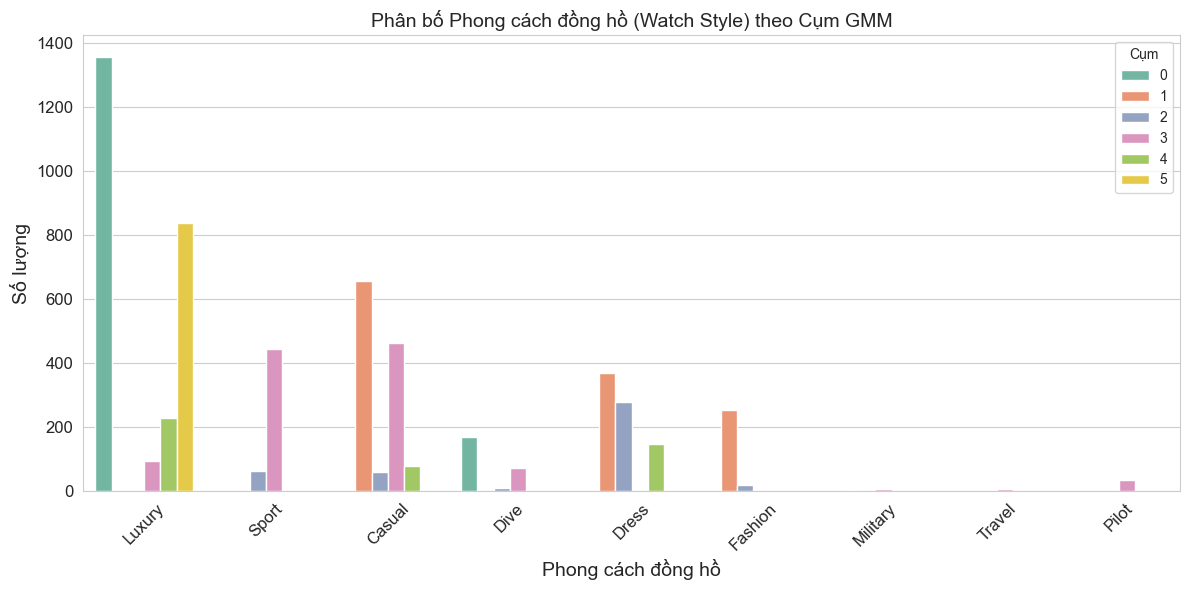

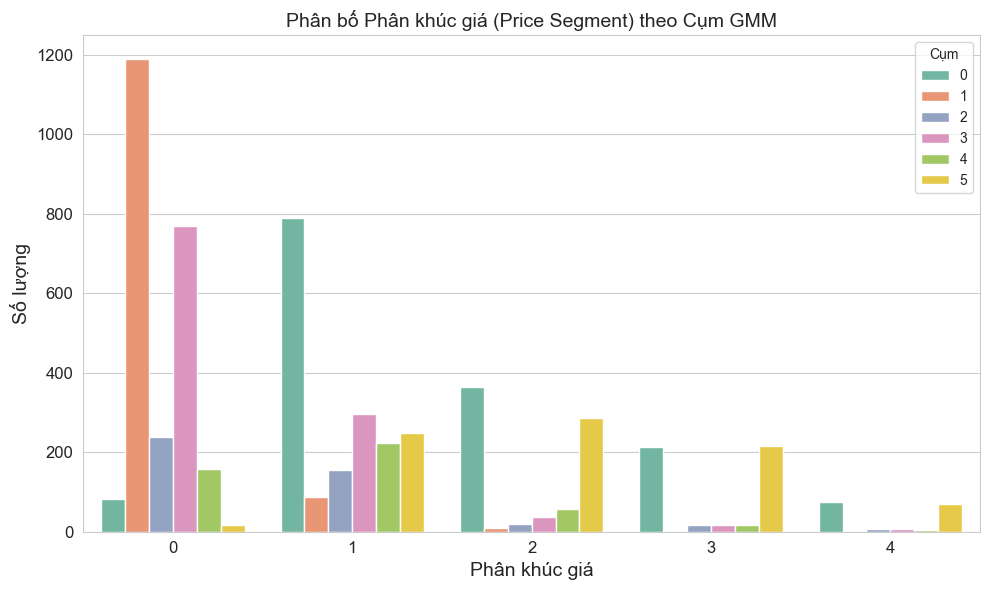

In [45]:
# Gender distribution by cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='gmm_cluster', data=df_original, palette='Set2')
plt.title('Phân bố Giới tính (Gender) theo Cụm GMM', fontsize=14)
plt.xlabel('Giới tính')
plt.ylabel('Số lượng')
plt.legend(title='Cụm')
plt.show()

# Movement type distribution by cluster
plt.figure(figsize=(10, 6))
movement_counts = df_original.groupby(['gmm_cluster', 'movement']).size().unstack()
movement_proportions = movement_counts.div(movement_counts.sum(axis=1), axis=0) * 100
movement_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
plt.title('Tỷ lệ loại Movement theo Cụm GMM', fontsize=14)
plt.xlabel('Cụm')
plt.ylabel('Phần trăm (%)')
plt.legend(title='Movement type')
plt.xticks(rotation=0)
plt.show()

# Watch style distribution by cluster
plt.figure(figsize=(12, 6))
sns.countplot(x='watch_style', hue='gmm_cluster', data=df_original, palette='Set2')
plt.title('Phân bố Phong cách đồng hồ (Watch Style) theo Cụm GMM', fontsize=14)
plt.xlabel('Phong cách đồng hồ')
plt.ylabel('Số lượng')
plt.legend(title='Cụm')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# price_segment distribution by cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='price_segment', hue='gmm_cluster', data=df_original, palette='Set2')
plt.title('Phân bố Phân khúc giá (Price Segment) theo Cụm GMM', fontsize=14)
plt.xlabel('Phân khúc giá')
plt.ylabel('Số lượng')
plt.legend(title='Cụm')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Tỷ lệ price_segment trong mỗi cụm GMM (%):
price_segment     0     1     2     3    4
gmm_cluster                               
0               5.4  51.7  23.9  14.0  4.9
1              92.5   6.8   0.7   0.0  0.0
2              54.8  35.3   4.6   3.9  1.4
3              68.6  26.3   3.2   1.4  0.5
4              34.6  48.6  12.3   3.7  0.9
5               2.1  29.7  34.2  25.7  8.2


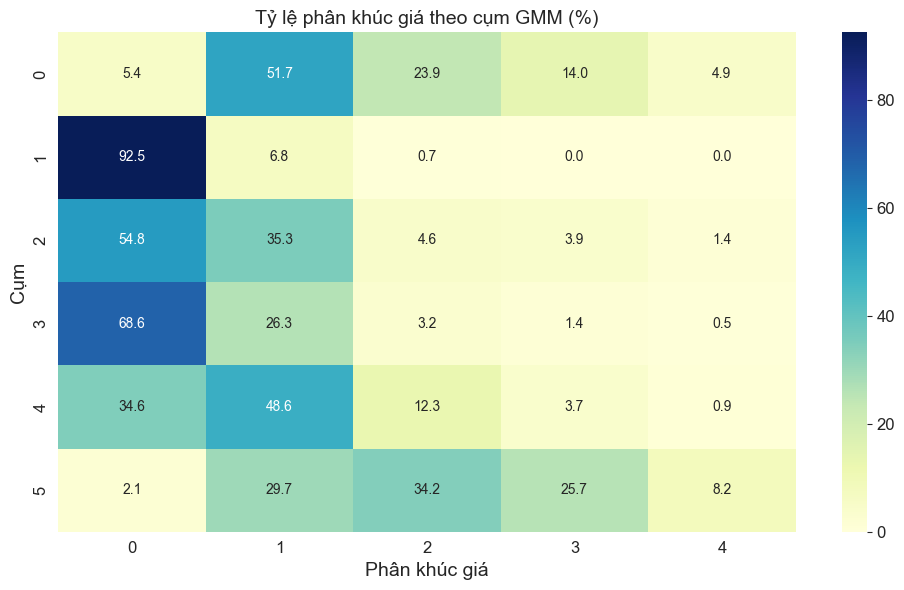

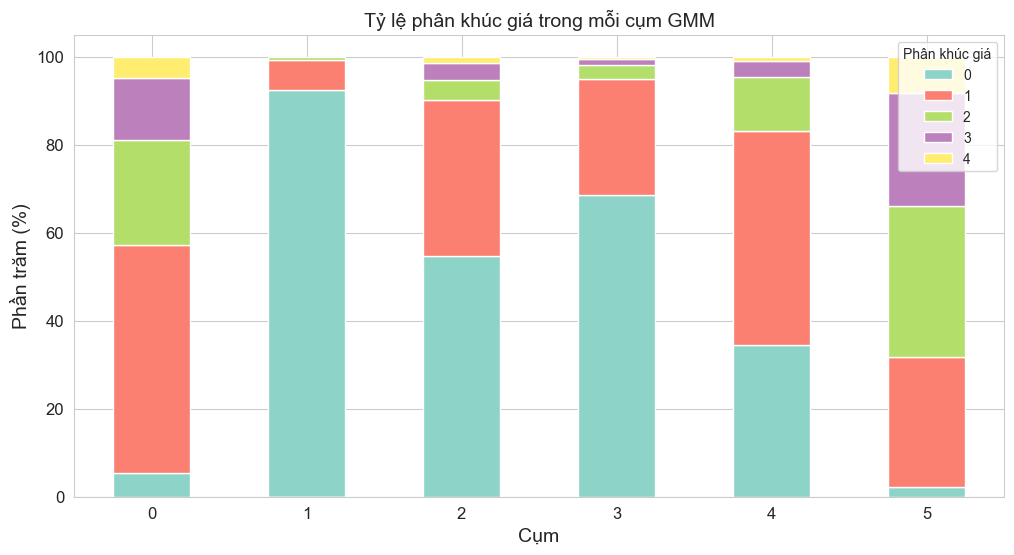

In [46]:
# Tạo bảng tỷ lệ price_segment trong mỗi cụm GMM
segment_cluster_df = pd.crosstab(df_original['gmm_cluster'], df_original['price_segment'], normalize='index') * 100
segment_cluster_df = segment_cluster_df.round(1)

print("Tỷ lệ price_segment trong mỗi cụm GMM (%):")
print(segment_cluster_df)

plt.figure(figsize=(10, 6))
sns.heatmap(segment_cluster_df, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Tỷ lệ phân khúc giá theo cụm GMM (%)', fontsize=14)
plt.xlabel('Phân khúc giá')
plt.ylabel('Cụm')
plt.tight_layout()
plt.show()

# Stacked bar chart cho price_segment theo cụm GMM
segment_counts = df_original.groupby(['gmm_cluster', 'price_segment']).size().unstack()
segment_proportions = segment_counts.div(segment_counts.sum(axis=1), axis=0) * 100
segment_proportions.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set3')
plt.title('Tỷ lệ phân khúc giá trong mỗi cụm GMM', fontsize=14)
plt.xlabel('Cụm')
plt.ylabel('Phần trăm (%)')
plt.legend(title='Phân khúc giá')
plt.xticks(rotation=0)
plt.show()

In [47]:
# Kiểm định chi-square giữa cụm GMM và price_segment
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df_original['gmm_cluster'], df_original['price_segment'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print("Kết luận: Có mối liên hệ có ý nghĩa thống kê giữa cụm và phân khúc giá" if p < 0.05 else "Kết luận: Không có mối liên hệ có ý nghĩa thống kê")

Chi-square statistic: 3616.28
p-value: 0.0000
Degrees of freedom: 20
Kết luận: Có mối liên hệ có ý nghĩa thống kê giữa cụm và phân khúc giá


### 6.3. Phân tích thương hiệu (Brand) theo cụm GMM

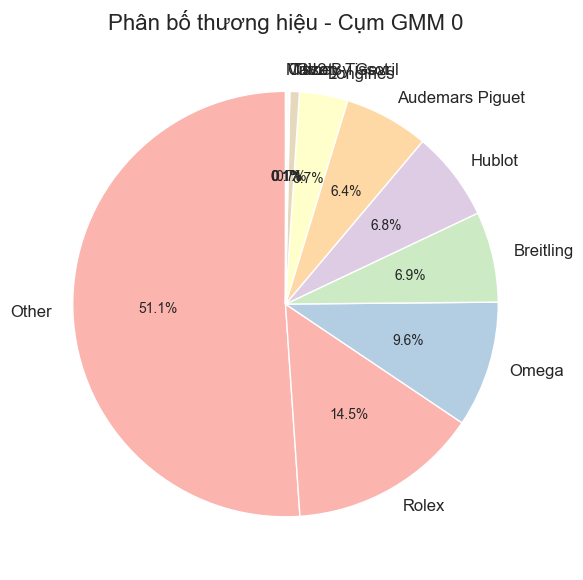

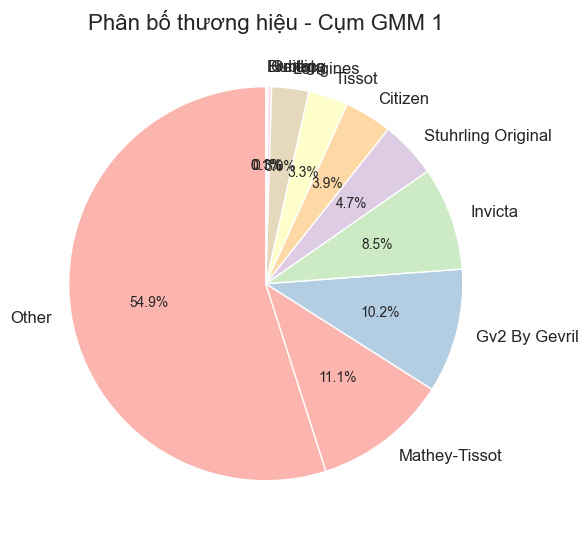

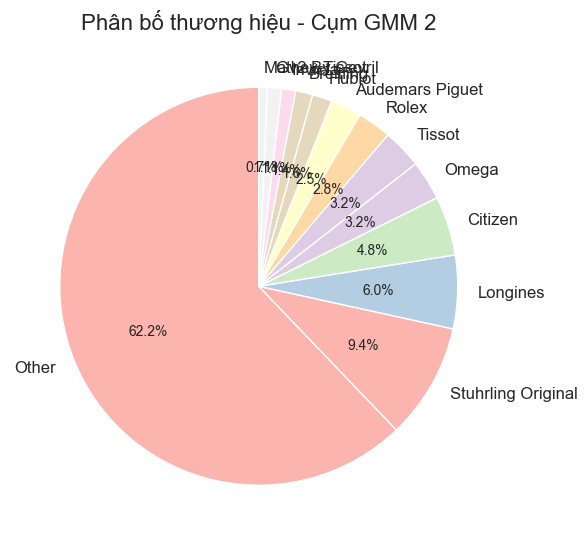

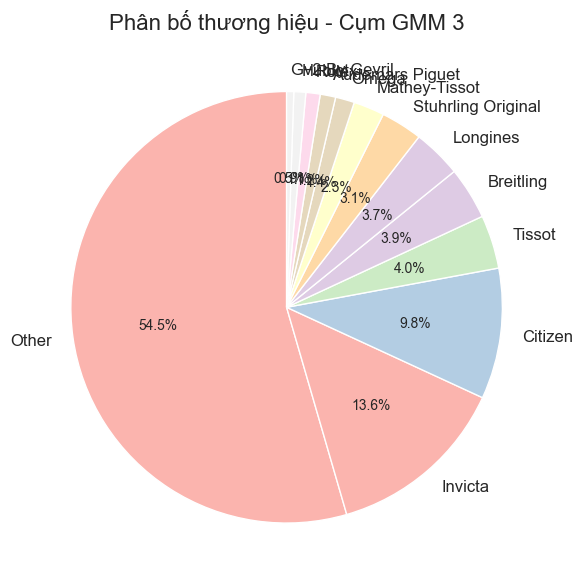

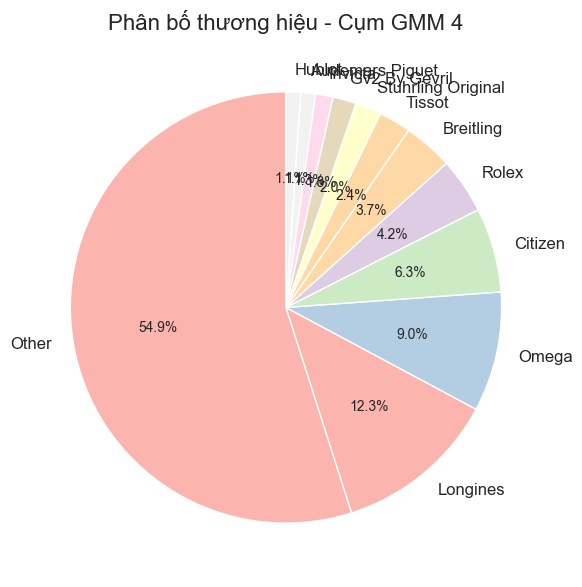

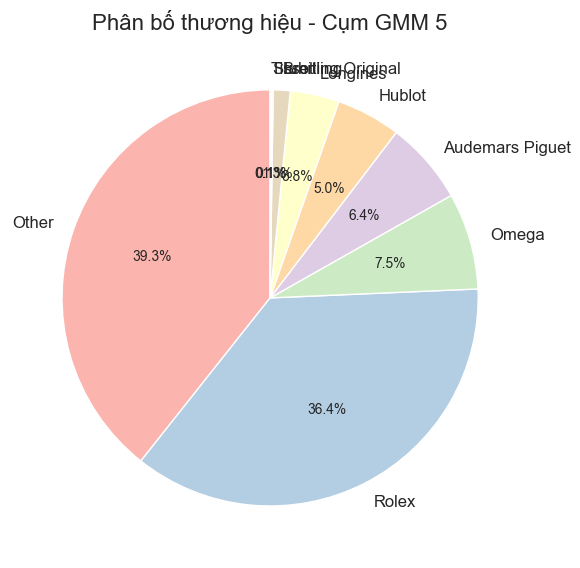

In [48]:
# Gộp thương hiệu hiếm thành 'Other'
def pool_categories(series, threshold=0.02):
    value_counts = series.value_counts(normalize=True)
    rare = value_counts[value_counts < threshold].index
    return series.apply(lambda x: 'Other' if x in rare else x)

df_original['brand_pooled'] = pool_categories(df_original['brand'], threshold=0.02)

for cluster_id in sorted(df_original['gmm_cluster'].unique()):
    plt.figure(figsize=(6, 6))
    brand_counts = df_original[df_original['gmm_cluster'] == cluster_id]['brand_pooled'].value_counts()
    brand_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel1')
    plt.title(f"Phân bố thương hiệu - Cụm GMM {cluster_id}")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

## 7. Phân tích đa chiều (Multivariate Analysis) cho GMM

Biểu đồ tọa độ song song giúp so sánh các đặc trưng số và price_segment giữa các cụm GMM.

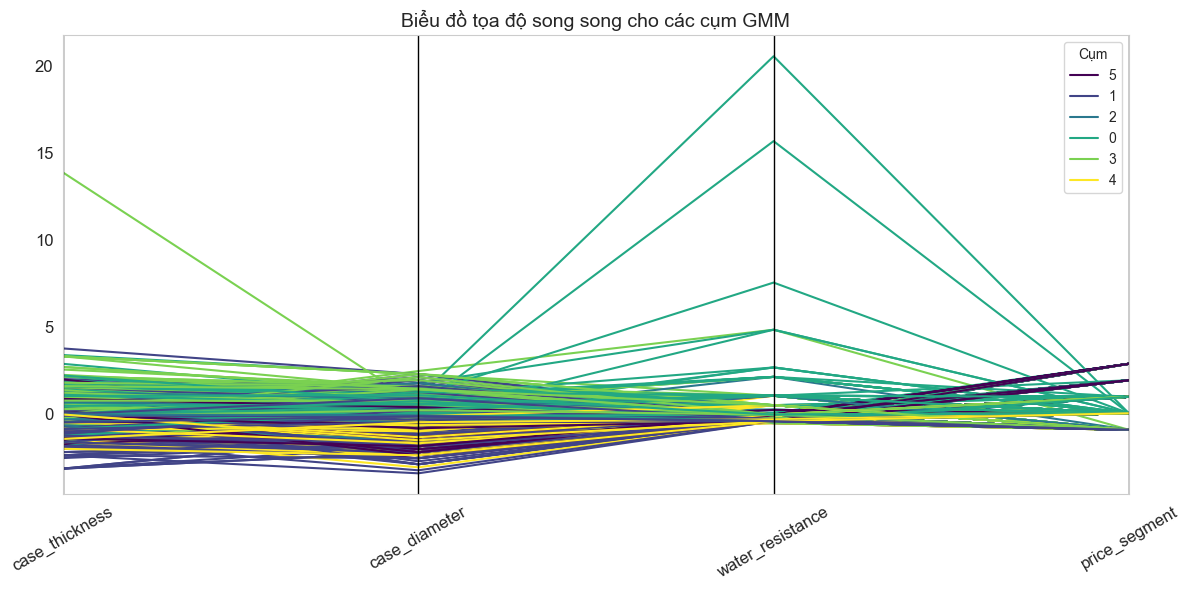

In [49]:
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler

parallel_features = num_cols + ['price_segment']
sample_size = min(1000, len(df_original))
df_sample = df_original.sample(sample_size, random_state=42) if len(df_original) > sample_size else df_original
parallel_df = df_sample[parallel_features + ['gmm_cluster']].copy()
scaler = StandardScaler()
parallel_df[parallel_features] = scaler.fit_transform(parallel_df[parallel_features])

plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_df, 'gmm_cluster', colormap='viridis')
plt.title('Biểu đồ tọa độ song song cho các cụm GMM', fontsize=14)
plt.grid(False)
plt.legend(title='Cụm')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## 8. Phân tích mối quan hệ giữa các đặc trưng số theo cụm GMM

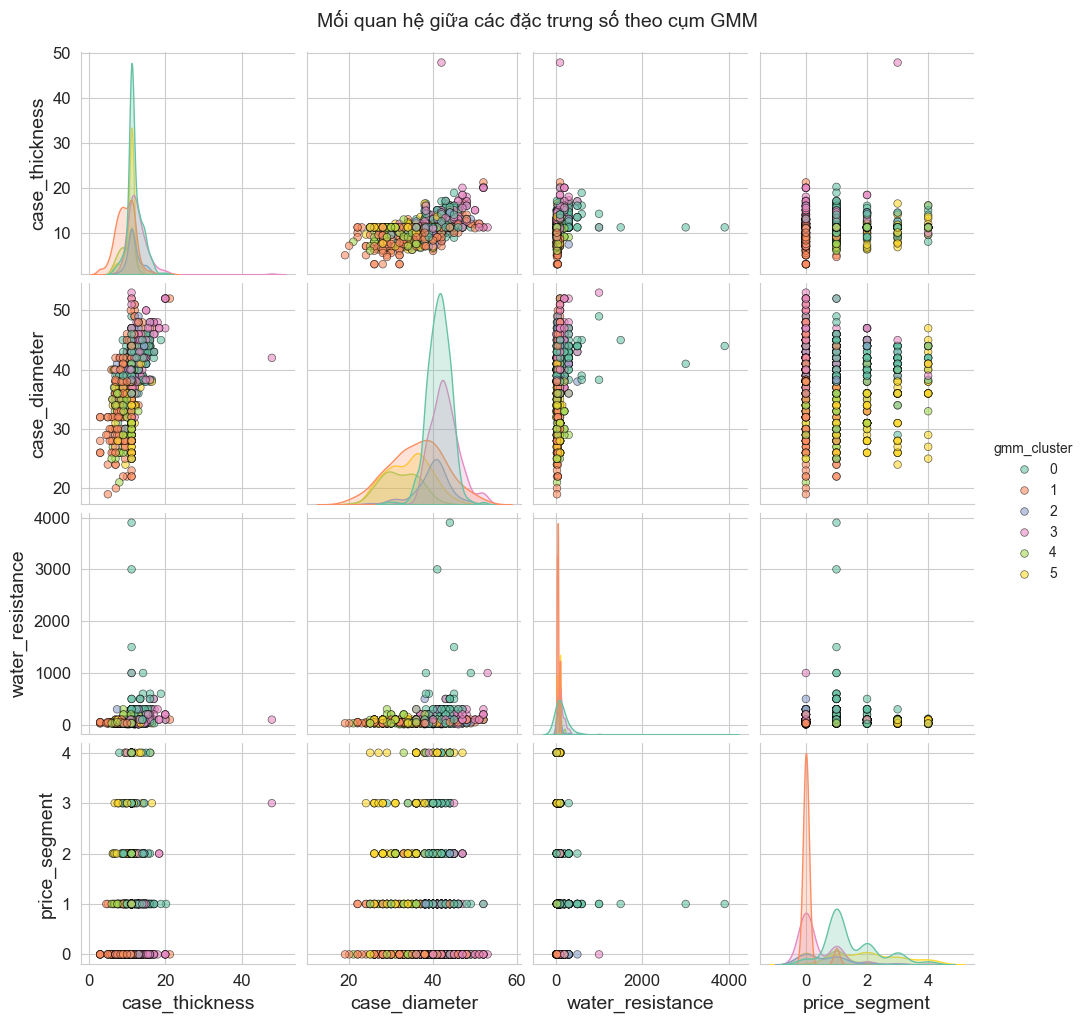

In [50]:
sns.pairplot(df_sample, vars=num_cols + ['price_segment'], hue='gmm_cluster', palette='Set2', 
             height=2.5, plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k', 'linewidth': 0.5})
plt.suptitle('Mối quan hệ giữa các đặc trưng số theo cụm GMM', y=1.02, fontsize=14)
plt.show()

## 9. Đặc điểm và phân loại các cụm GMM

Dựa trên các phân tích trên, bạn có thể mô tả đặc điểm từng cụm GMM tương tự như phần Agglomerative Clustering để so sánh.

Tóm tắt các cụm GMM:
   gmm_cluster  sample_count  percentage
0            0          1525   26.919682
1            1          1285   22.683142
2            3          1123   19.823477
3            5           839   14.810238
4            4           457    8.067079
5            2           436    7.696381


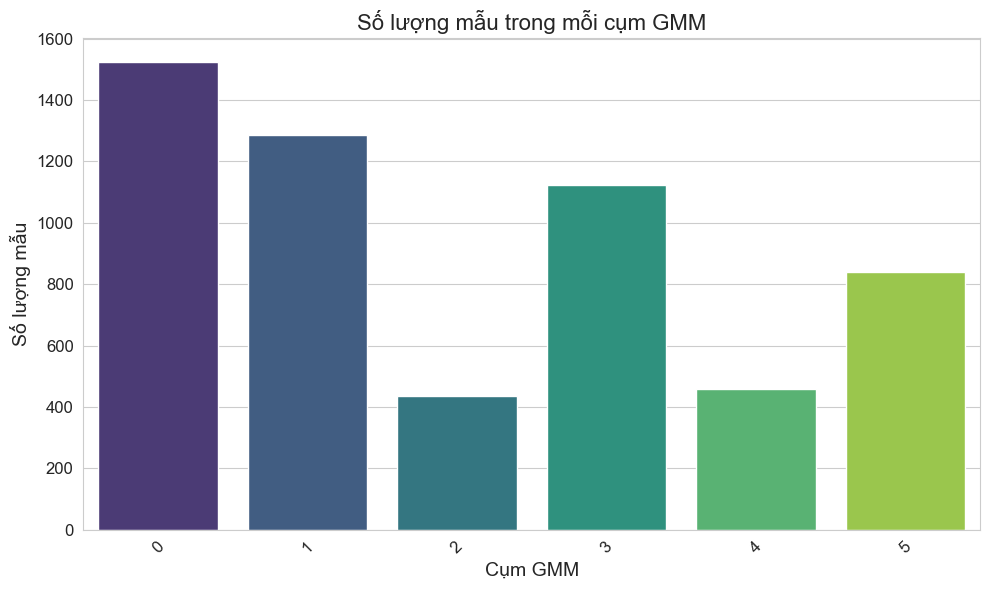


Đặc điểm cụm GMM 0:
       case_thickness  case_diameter  water_resistance  price_segment
count     1525.000000    1525.000000       1525.000000    1525.000000
mean        12.028801      41.307460        150.474668       1.613770
std          1.942077       2.833357        301.251986       0.959656
min          4.300000      23.000000          3.000000       0.000000
25%         11.196182      40.000000         50.000000       1.000000
50%         11.196182      41.000000        100.000000       1.000000
75%         13.000000      43.000000        150.000000       2.000000
max         20.200000      54.000000       6000.000000       4.000000


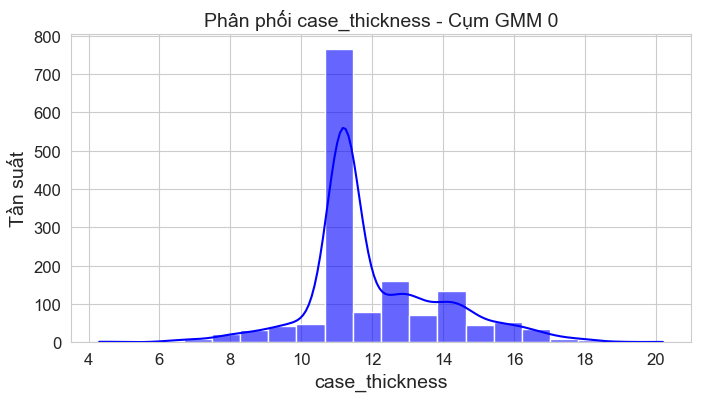

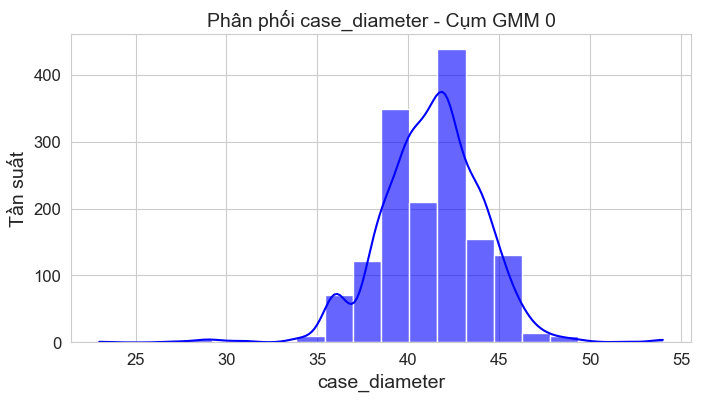

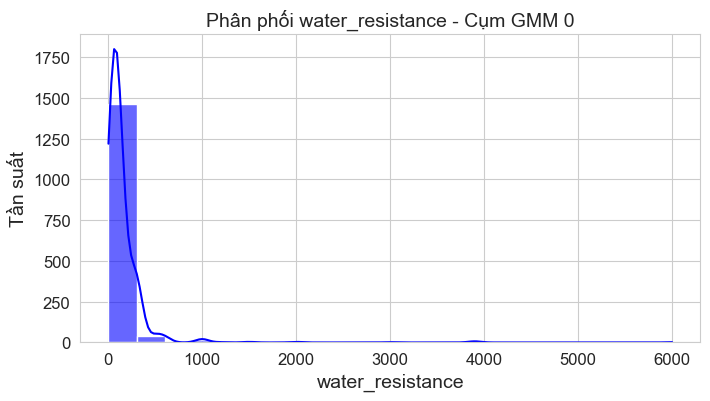


Đặc điểm cụm GMM 1:
       case_thickness  case_diameter  water_resistance  price_segment
count     1285.000000    1285.000000       1285.000000    1285.000000
mean         9.722089      36.662791         51.240979       0.081712
std          2.450922       6.670246         25.378763       0.298517
min          3.000000      16.000000          3.000000       0.000000
25%          8.000000      32.000000         30.000000       0.000000
50%         10.000000      37.000000         50.000000       0.000000
75%         11.196182      42.000000         50.000000       0.000000
max         21.200000      58.000000        200.000000       2.000000


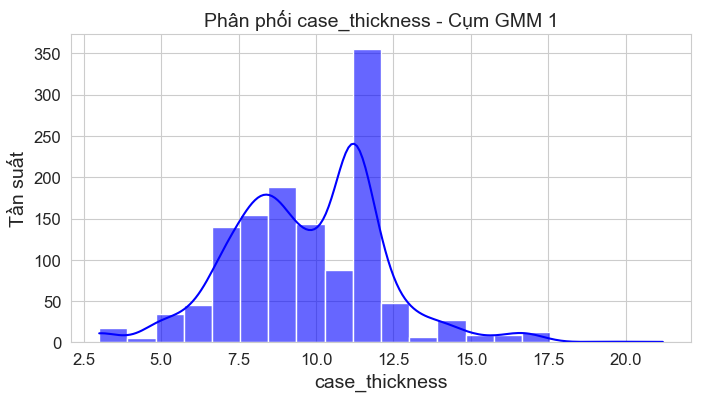

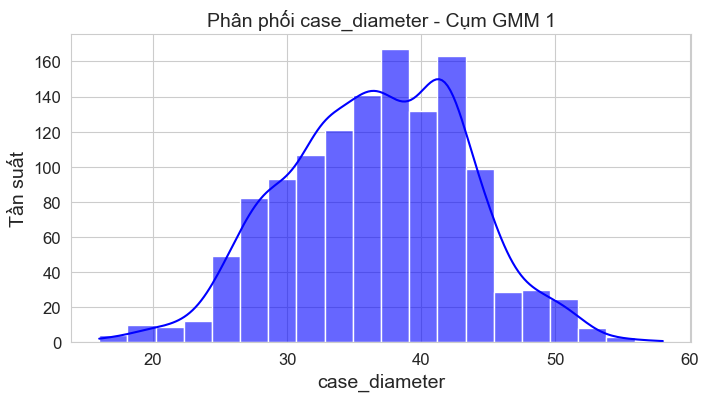

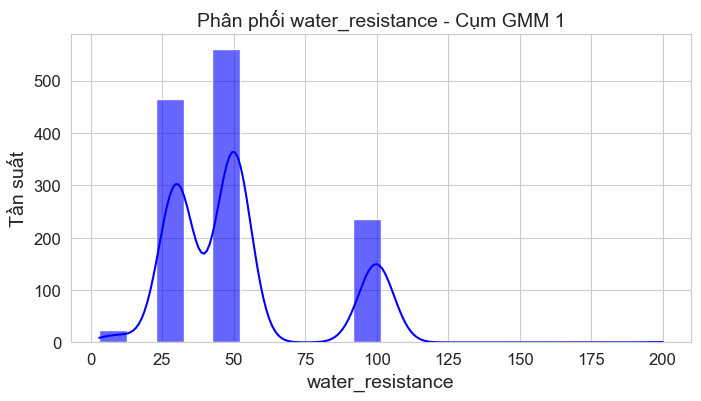


Đặc điểm cụm GMM 2:
       case_thickness  case_diameter  water_resistance  price_segment
count      436.000000     436.000000        436.000000     436.000000
mean        11.486402      39.938291         83.937424       0.616972
std          2.011053       4.115456         87.468190       0.853706
min          2.400000      22.000000          3.000000       0.000000
25%         10.770000      38.000000         30.000000       0.000000
50%         11.196182      40.000000         50.000000       0.000000
75%         12.500000      42.000000        100.000000       1.000000
max         22.500000      54.000000       1000.000000       4.000000


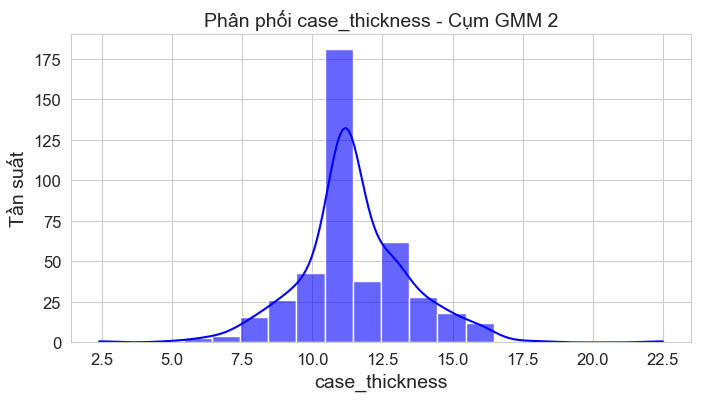

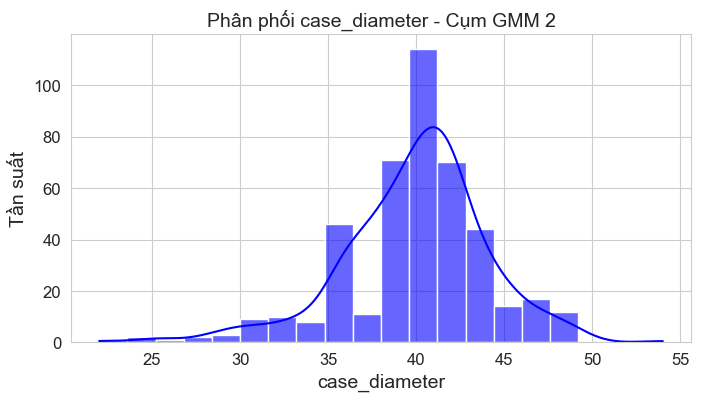

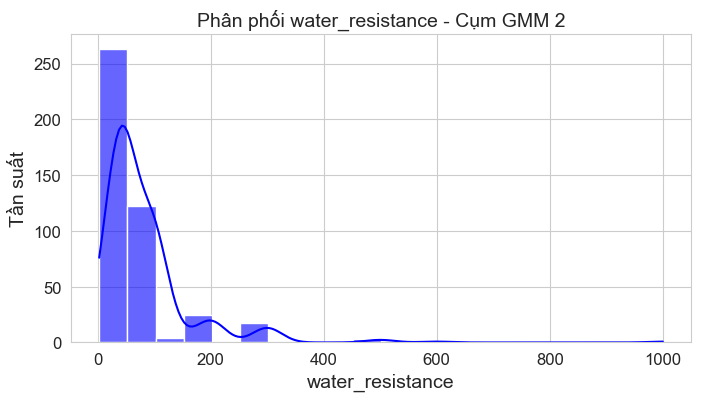


Đặc điểm cụm GMM 3:
       case_thickness  case_diameter  water_resistance  price_segment
count     1123.000000    1123.000000       1123.000000    1123.000000
mean        12.726228      42.708621        123.840301       0.390917
std          3.146999       3.711303        119.862182       0.672471
min          4.000000      18.000000         10.000000       0.000000
25%         11.196182      40.000000         50.000000       0.000000
50%         12.000000      42.000000        100.000000       0.000000
75%         14.000000      45.000000        200.000000       1.000000
max         66.200000      58.000000       1200.000000       4.000000


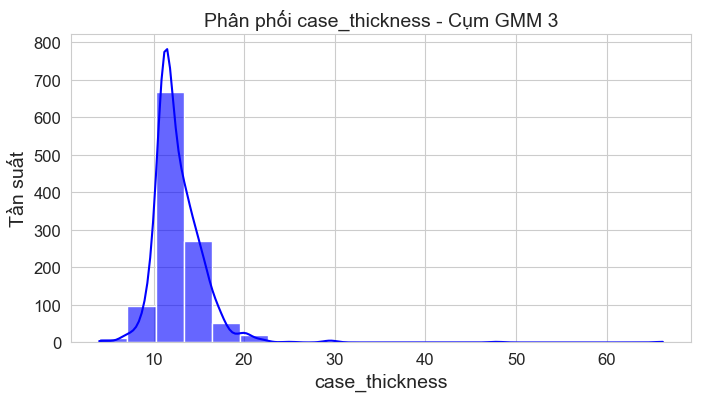

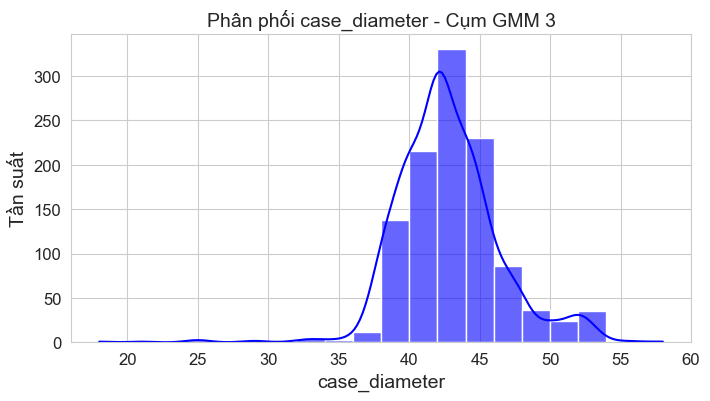

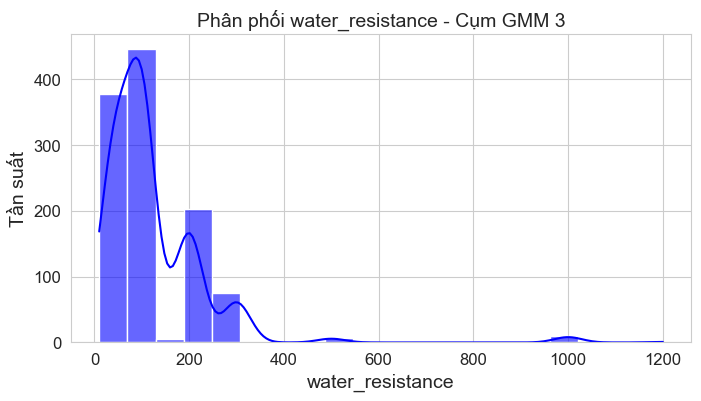


Đặc điểm cụm GMM 4:
       case_thickness  case_diameter  water_resistance  price_segment
count      457.000000     457.000000        457.000000     457.000000
mean         9.903460      31.751633         60.083741       0.877462
std          1.736096       4.791077         50.441141       0.826027
min          3.900000      12.000000         10.000000       0.000000
25%          8.500000      28.000000         30.000000       0.000000
50%         10.500000      32.000000         50.000000       1.000000
75%         11.196182      36.000000         50.000000       1.000000
max         15.800000      45.000000        500.000000       4.000000


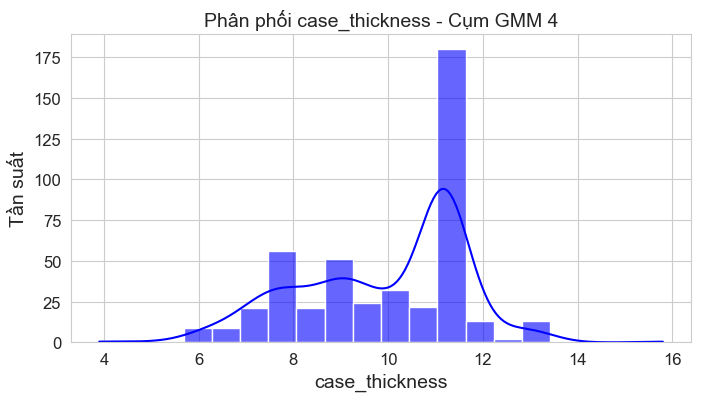

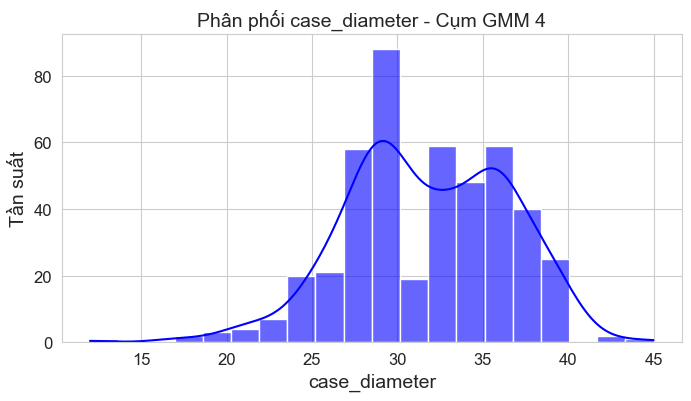

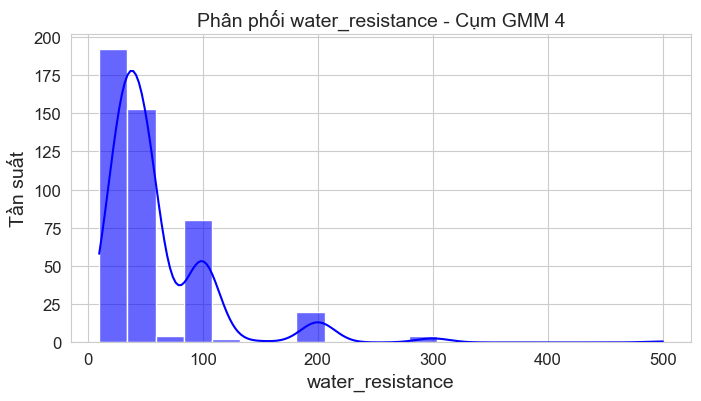


Đặc điểm cụm GMM 5:
       case_thickness  case_diameter  water_resistance  price_segment
count      839.000000     839.000000        839.000000     839.000000
mean        10.816274      34.050051         73.264836       2.082241
std          1.391327       5.412323         40.109926       0.981527
min          4.130000      12.000000         20.000000       0.000000
25%         11.050000      30.500000         30.000000       1.000000
50%         11.196182      34.000000        100.000000       2.000000
75%         11.196182      38.000000        100.000000       3.000000
max         16.500000      50.000000        300.000000       4.000000


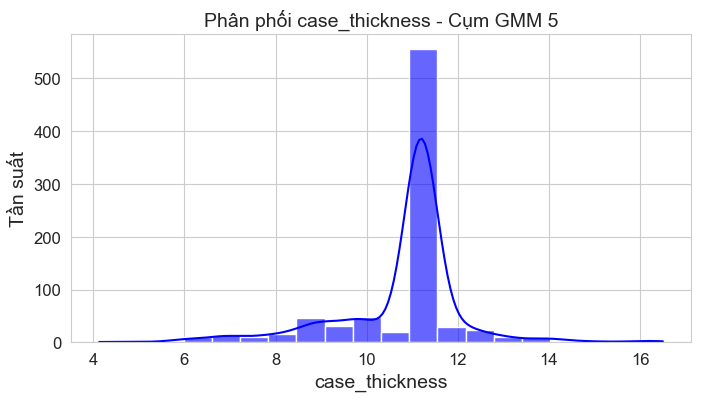

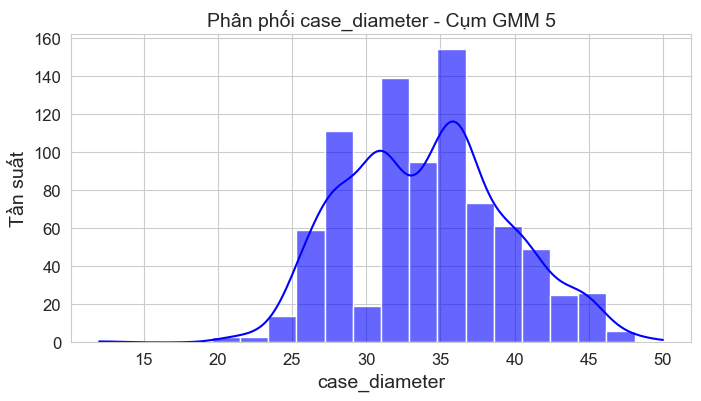

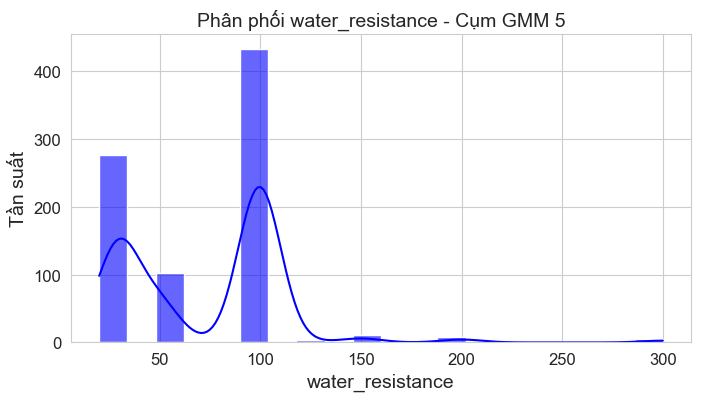

In [51]:
# Xuất danh sách các cụm GMM và số lượng mẫu trong mỗi cụm
gmm_cluster_counts = df_original['gmm_cluster'].value_counts().reset_index()
gmm_cluster_counts.columns = ['gmm_cluster', 'sample_count']

# Tính toán tỷ lệ phần trăm cho mỗi cụm
total_samples = len(df_original)
gmm_cluster_counts['percentage'] = (gmm_cluster_counts['sample_count'] / total_samples) * 100

# Sắp xếp theo thứ tự giảm dần của số lượng mẫu
gmm_cluster_counts = gmm_cluster_counts.sort_values(by='sample_count', ascending=False)

# Hiển thị bảng tóm tắt cụm GMM
print("Tóm tắt các cụm GMM:")
print(gmm_cluster_counts)

# Biểu đồ số lượng mẫu trong mỗi cụm GMM
plt.figure(figsize=(10, 6))
sns.barplot(data=gmm_cluster_counts, x='gmm_cluster', y='sample_count', palette='viridis')
plt.title('Số lượng mẫu trong mỗi cụm GMM', fontsize=16)
plt.xlabel('Cụm GMM')
plt.ylabel('Số lượng mẫu')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Phân tích đặc điểm từng cụm GMM dựa trên các đặc trưng số
for cluster_id in sorted(df_original['gmm_cluster'].unique()):
    print(f"\nĐặc điểm cụm GMM {cluster_id}:")
    cluster_profile = df_original[df_original['gmm_cluster'] == cluster_id][num_cols + ['price_segment']]
    print(cluster_profile.describe())
    
    # Vẽ biểu đồ phân phối cho từng đặc trưng số
    for col in num_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(cluster_profile[col], bins=20, kde=True, color='blue', alpha=0.6)
        plt.title(f'Phân phối {col} - Cụm GMM {cluster_id}', fontsize=14)
        plt.xlabel(col)
        plt.ylabel('Tần suất')
        plt.grid(True)
        plt.show()

# Phân cụm dữ liệu đồng hồ bằng Agglomerative Clustering


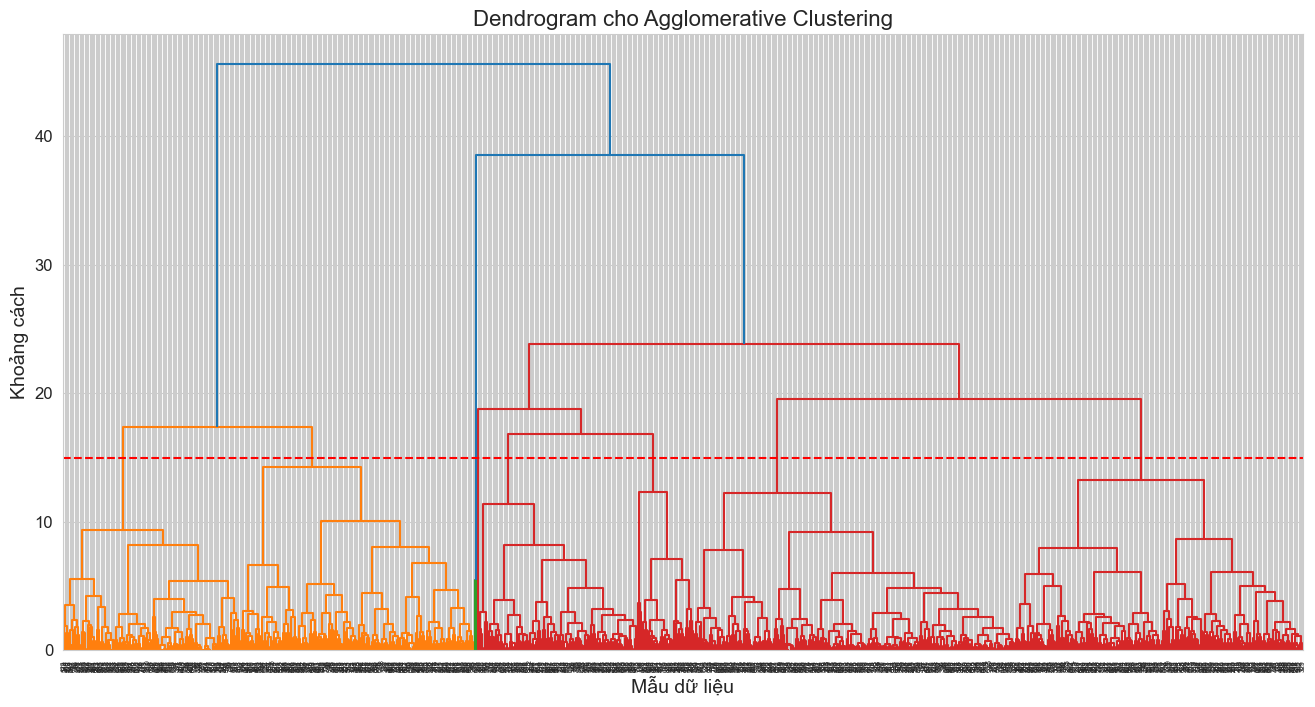

In [52]:
# Vẽ dendrogram để xác định số cụm tối ưu
plt.figure(figsize=(16, 8))
plt.title('Dendrogram cho Agglomerative Clustering', fontsize=16)
plt.xlabel('Mẫu dữ liệu', fontsize=14)
plt.ylabel('Khoảng cách', fontsize=14)

# Sử dụng mẫu nhỏ nếu dữ liệu quá lớn
sample_size = min(1000, len(df_agg))
sample_data = df_agg.sample(sample_size, random_state=42) if len(df_agg) > sample_size else df_agg

# Tính toán linkage matrix
linkage_matrix = linkage(sample_data, method='ward')

# Vẽ dendrogram
dendrogram(linkage_matrix)
plt.axhline(y=15, color='r', linestyle='--')  # Đường tham chiếu để chọn số cụm
plt.show()

n_clusters = 2:
  Silhouette Score: 0.2665
  Davies-Bouldin Score: 1.4043
  Calinski-Harabasz Score: 1754.2411
n_clusters = 3:
  Silhouette Score: 0.2723
  Davies-Bouldin Score: 1.0051
  Calinski-Harabasz Score: 1618.7676
n_clusters = 4:
  Silhouette Score: 0.1456
  Davies-Bouldin Score: 1.4441
  Calinski-Harabasz Score: 1415.9526
n_clusters = 5:
  Silhouette Score: 0.1540
  Davies-Bouldin Score: 1.3627
  Calinski-Harabasz Score: 1287.6890
n_clusters = 6:
  Silhouette Score: 0.1561
  Davies-Bouldin Score: 1.5424
  Calinski-Harabasz Score: 1176.9280
n_clusters = 7:
  Silhouette Score: 0.1432
  Davies-Bouldin Score: 1.6121
  Calinski-Harabasz Score: 1120.0489
n_clusters = 8:
  Silhouette Score: 0.1515
  Davies-Bouldin Score: 1.5445
  Calinski-Harabasz Score: 1048.8867


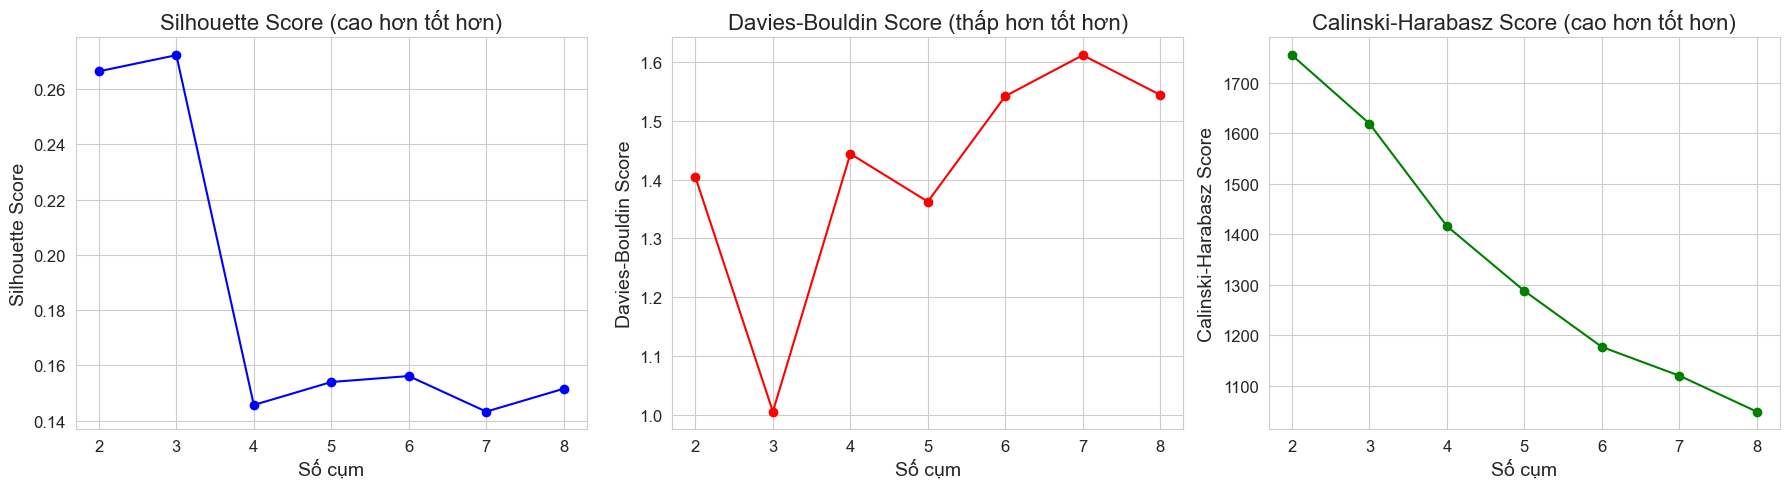

In [54]:
from sklearn.cluster import AgglomerativeClustering

# Thử nghiệm với một số lượng cụm khác nhau
n_clusters_list = [2, 3, 4, 5, 6, 7, 8]
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for n_clusters in n_clusters_list:
    # Áp dụng Agglomerative Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = agg_clustering.fit_predict(df_agg)
    
    # Tính các chỉ số đánh giá
    silhouette = silhouette_score(df_agg, cluster_labels)
    davies_bouldin = davies_bouldin_score(df_agg, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(df_agg, cluster_labels)
    
    # Lưu kết quả
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)
    
    print(f"n_clusters = {n_clusters}:")
    print(f"  Silhouette Score: {silhouette:.4f}")
    print(f"  Davies-Bouldin Score: {davies_bouldin:.4f}")
    print(f"  Calinski-Harabasz Score: {calinski_harabasz:.4f}")

# Vẽ biểu đồ kết quả
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(n_clusters_list, silhouette_scores, 'o-', color='blue')
ax[0].set_xlabel('Số cụm')
ax[0].set_ylabel('Silhouette Score')
ax[0].set_title('Silhouette Score (cao hơn tốt hơn)')

ax[1].plot(n_clusters_list, davies_bouldin_scores, 'o-', color='red')
ax[1].set_xlabel('Số cụm')
ax[1].set_ylabel('Davies-Bouldin Score')
ax[1].set_title('Davies-Bouldin Score (thấp hơn tốt hơn)')

ax[2].plot(n_clusters_list, calinski_harabasz_scores, 'o-', color='green')
ax[2].set_xlabel('Số cụm')
ax[2].set_ylabel('Calinski-Harabasz Score')
ax[2].set_title('Calinski-Harabasz Score (cao hơn tốt hơn)')

plt.tight_layout()
plt.show()


Số cụm tối ưu dựa trên Silhouette Score: 3

=== PHÂN TÍCH PHÂN PHỐI CỦA CÁC CỤM ===
cluster
0    3801
1    1858
2       6
Name: count, dtype: int64

Phần trăm phân phối:
cluster
0    67.096205
1    32.797882
2     0.105914
Name: count, dtype: float64


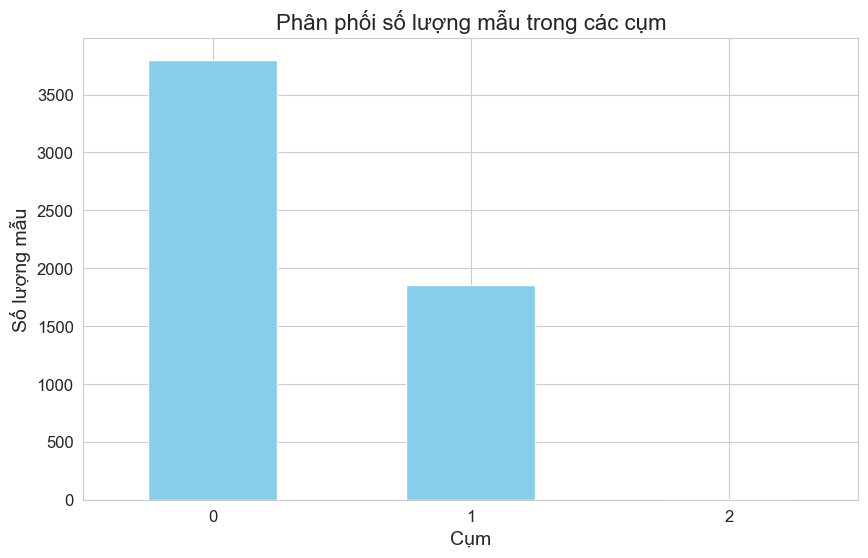

In [55]:
# Chọn số cụm tối ưu dựa trên kết quả
optimal_n_clusters = n_clusters_list[silhouette_scores.index(max(silhouette_scores))]
print(f"\nSố cụm tối ưu dựa trên Silhouette Score: {optimal_n_clusters}")

# Áp dụng Agglomerative Clustering với số cụm tối ưu
final_model = AgglomerativeClustering(n_clusters=optimal_n_clusters, linkage='ward')
df['cluster'] = final_model.fit_predict(df_agg)

# Phân tích kết quả phân cụm
print("\n=== PHÂN TÍCH PHÂN PHỐI CỦA CÁC CỤM ===")
cluster_counts = df['cluster'].value_counts().sort_index()
print(cluster_counts)
print("\nPhần trăm phân phối:")
print(100 * cluster_counts / len(df))

# Trực quan hóa phân phối cụm
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('Phân phối số lượng mẫu trong các cụm')
plt.xlabel('Cụm')
plt.ylabel('Số lượng mẫu')
plt.xticks(rotation=0)
plt.show()



# So sánh các metrics


Agglomerative Clustering:
Silhouette Score: 0.2723
Davies-Bouldin Index: 1.0051
Calinski-Harabasz Index: 1618.7676


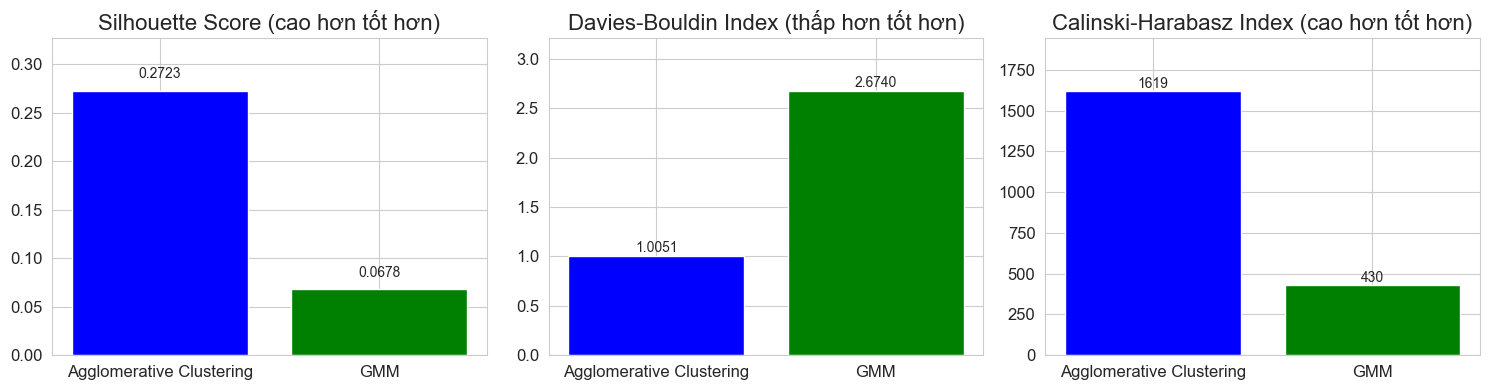


=== BẢNG KẾT QUẢ ĐÁNH GIÁ CÁC MÔ HÌNH ===
                      Model  Silhouette Score  Davies-Bouldin Index  \
0  Agglomerative Clustering          0.272319              1.005079   
1                       GMM          0.067766              2.673992   

   Calinski-Harabasz Index  
0              1618.767614  
1               429.717912  


In [56]:
metrics_results = []


# Tính metrics cho Agglomerative Clustering
silhouette = silhouette_score(df_agg, df['cluster'])
davies_bouldin = davies_bouldin_score(df_agg, df['cluster'])
calinski_harabasz = calinski_harabasz_score(df_agg, df['cluster'])

print(f"\nAgglomerative Clustering:")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")

metrics_results.append(['Agglomerative Clustering', silhouette, davies_bouldin, calinski_harabasz])

gmm_silhouette = silhouette_score(df_gmm, gmm_clusters)
gmm_davies_bouldin = davies_bouldin_score(df_gmm, gmm_clusters)
gmm_calinski_harabasz = calinski_harabasz_score(df_gmm, gmm_clusters)

# Cập nhật bảng metrics để bao gồm GMM
metrics_results.append(['GMM', gmm_silhouette, gmm_davies_bouldin, gmm_calinski_harabasz])

# Tạo DataFrame để hiển thị kết quả
metrics_df = pd.DataFrame(metrics_results, 
                         columns=['Model', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

# Vẽ biểu đồ so sánh Silhouette Score
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
bars = plt.bar(metrics_df['Model'], metrics_df['Silhouette Score'], color=['blue', 'green'])
plt.title('Silhouette Score (cao hơn tốt hơn)')
plt.ylim(0, max(metrics_df['Silhouette Score'][~np.isnan(metrics_df['Silhouette Score'])]) * 1.2)
for bar in bars:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

# Vẽ biểu đồ so sánh Davies-Bouldin Index
plt.subplot(1, 3, 2)
bars = plt.bar(metrics_df['Model'], metrics_df['Davies-Bouldin Index'], color=['blue', 'green'])
plt.title('Davies-Bouldin Index (thấp hơn tốt hơn)')
plt.ylim(0, max(metrics_df['Davies-Bouldin Index'][~np.isnan(metrics_df['Davies-Bouldin Index'])]) * 1.2)
for bar in bars:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

# Vẽ biểu đồ so sánh Calinski-Harabasz Index
plt.subplot(1, 3, 3)
bars = plt.bar(metrics_df['Model'], metrics_df['Calinski-Harabasz Index'], color=['blue', 'green'])
plt.title('Calinski-Harabasz Index (cao hơn tốt hơn)')
plt.ylim(0, max(metrics_df['Calinski-Harabasz Index'][~np.isnan(metrics_df['Calinski-Harabasz Index'])]) * 1.2)
for bar in bars:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Hiển thị bảng kết quả đánh giá
print("\n=== BẢNG KẾT QUẢ ĐÁNH GIÁ CÁC MÔ HÌNH ===")
print(metrics_df)